In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import scipy.misc, random, os
import numpy as np

# Google Earth Engine
import ee
from gee_library import *
ee.Initialize()

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Threads
import time, Queue
from tqdm import trange
from threading import Thread

# Tensorflow
import tensorflow as tf

from google.protobuf.internal import api_implementation
print(api_implementation._default_implementation_type)


cpp


# Globals

In [ ]:
DATA_DIR="data/experiment"
TEST_PROTO_FILENAME = os.path.join(DATA_DIR,"multi_spectrum_test.tfrecords")
TRAINING_PROTO_FILENAME = os.path.join(DATA_DIR,"multi_spectrum_train.tfrecords")

In [2]:
def get_batch(proto_filename, batch_size):

    NUMBER_OF_CLASSES=3
    
    filename_queue = tf.train.string_input_producer([proto_filename], num_epochs=None)
    proto_reader = tf.TFRecordReader()

    # get an example from file
    _, serialized_example = proto_reader.read(filename_queue)

    # unpack it
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'R': tf.FixedLenFeature([50*50], tf.int64),
            'G': tf.FixedLenFeature([50*50], tf.int64),
            'B': tf.FixedLenFeature([50*50], tf.int64),
            'elevation': tf.FixedLenFeature([50*50], tf.int64),
            'nightlights': tf.FixedLenFeature([50*50], tf.int64),
        })

    # now we have the raw data. Wrangle it into the right dimentions
    R = tf.divide(tf.cast(features['R'], tf.float32), 255)
    G = tf.divide(tf.cast(features['G'], tf.float32), 255)
    B = tf.divide(tf.cast(features['B'], tf.float32), 255)
    elevation = tf.divide(tf.cast(features['elevation'], tf.float32), 255)
    nightlights = tf.divide(tf.cast(features['nightlights'], tf.float32), 255)
    
    # The label is an integer; convert it to a one-hot array
    label = tf.one_hot(features['label'], NUMBER_OF_CLASSES)

    # and batch it
    R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch = tf.train.shuffle_batch(
        [R, G, B, elevation, nightlights, label],
        batch_size=batch_size,
        capacity=2000,
        min_after_dequeue=1000)

    return R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch

In [3]:
#
# Required input placeholders
#
training = tf.placeholder(dtype=tf.bool, name="is_training") # True if training, False if testing
batch_size = tf.placeholder(dtype=tf.int32, name="batch_size")


#
# Load the correct training/test data
#

R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch = get_batch(TRAIN_PROTO_FILENAME, batch_size)

#
# Model
#

x = tf.stack(values=[R_batch, G_batch, B_batch, elevation_batch, nightlight_batch],
             axis=2)
y_ = labels_batch


input_norm = tf.contrib.layers.batch_norm(x, 
                                  center=True, scale=True, 
                                  is_training=training)



# # Ensure our images are the correct shape
input_layer = tf.reshape(input_norm, [-1, 50, 50, 5])


#
# Convolution and Pooling Layers
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
# pool1_norm = tf.contrib.layers.batch_norm(pool1, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
# pool2_norm = tf.contrib.layers.batch_norm(pool2, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #3 (no pooling)
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
# conv3_norm = tf.contrib.layers.batch_norm(conv3, center=True, scale=True, activation=tf.nn.relu, is_training=training)


#
# Fully Connected Layers
#


# Dense Layer
conv3_flat = tf.reshape(conv3, [-1, 9 * 9 * 64])
fc1 = tf.layers.dense(inputs=conv3_flat, units=1024, activation=tf.nn.relu)
# fc1_norm = tf.contrib.layers.batch_norm(fc1, center=True, scale=True, activation=tf.nn.relu, is_training=training)
dropout = tf.layers.dropout(
    inputs=fc1,
    rate=0.6,
    training= True)

# Model Output. This will be a one-hot array.
y = tf.layers.dense(inputs=dropout, units=3)



#
# Loss
#

loss = None
train_op = None

loss = tf.losses.softmax_cross_entropy(
    onehot_labels=y_, # ground truth
    logits=y) # network output

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_softmax = tf.nn.softmax(y)

Label: [[ 1.  0.  0.]]


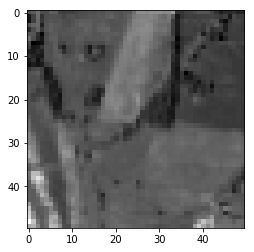

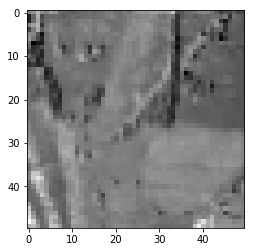

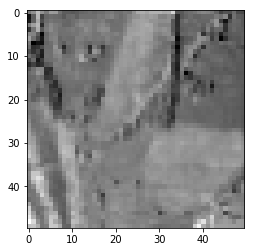

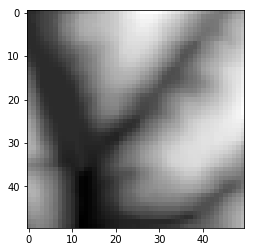

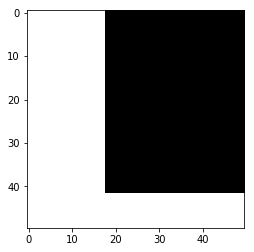

ERROR:tensorflow:Exception in QueueRunner: Attempted to use a closed Session.
ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer, input_producer/RandomShuffle)]]

Caused by op u'input_producer/input_producer_EnqueueMany', defined at:
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/conda/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python2/lib/python2.7/site-p

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/opt/conda/envs/python2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/opt/conda/envs/python2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/tensorflow/python/training/queue_runner_impl.py", line 234, in _run
    sess.run(enqueue_op)
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 767, in run
    run_metadata_ptr)
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 903, in _run
    raise RuntimeError('Attempted to use a closed Session.')
RuntimeError: Attempted to use a closed Session.

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/opt/conda/envs/python2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/o

In [10]:
#
# Before we get started, let's make sure our network is loading the images correctly.
#


# Initialize tensorflow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
tf.train.start_queue_runners(sess=sess)

R,G,B,E,N,L = sess.run( fetches = [R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch],
                                 feed_dict={training: False, batch_size:1})

R = R.reshape((50,50))
G = G.reshape((50,50))
B = B.reshape((50,50))
E = E.reshape((50,50))
N = N.reshape((50,50))

print "Label:", L
plt.imshow(R, cmap='gray'); plt.show()
plt.imshow(G, cmap='gray'); plt.show()
plt.imshow(B, cmap='gray'); plt.show()
plt.imshow(E, cmap='gray'); plt.show()
plt.imshow(N, cmap='gray'); plt.show()


sess.close()

In [5]:
#
# Train
#

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Required for batch norm
with tf.control_dependencies(update_ops): # Required for batch norm
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 1e-5
    learning_rate = tf.train.exponential_decay(learning_rate = starter_learning_rate,
                                               global_step = global_step,
                                               decay_steps = 200,
                                               decay_rate = 0.96,
                                               staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)


# Initialize TensorFlow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
tf.train.start_queue_runners(sess=sess)

# And run 20k iterations
for i in range(12000):
    if i%100 == 0:
        train_accuracy, loss_out, lr = sess.run( fetches = [model_accuracy, loss, learning_rate],
                                                 feed_dict={training: False, batch_size:128})
        print "Step", i, "Loss:", loss_out, "Accuracy:", train_accuracy, "LR:", lr
        
    # run an iteration
    optimizer.run(feed_dict={batch_size:128,
                             training: True})


Step 0 Loss: 1.09279 Accuracy: 0.367188 LR: 1e-05
Step 100 Loss: 0.793938 Accuracy: 0.554688 LR: 1e-05
Step 200 Loss: 0.731919 Accuracy: 0.648438 LR: 9.6e-06
Step 300 Loss: 0.680743 Accuracy: 0.671875 LR: 9.6e-06
Step 400 Loss: 0.767556 Accuracy: 0.546875 LR: 9.216e-06
Step 500 Loss: 0.69337 Accuracy: 0.640625 LR: 9.216e-06
Step 600 Loss: 0.759282 Accuracy: 0.5625 LR: 8.84736e-06
Step 700 Loss: 0.900759 Accuracy: 0.414062 LR: 8.84736e-06
Step 800 Loss: 0.64206 Accuracy: 0.742188 LR: 8.49346e-06
Step 900 Loss: 0.726088 Accuracy: 0.664062 LR: 8.49346e-06
Step 1000 Loss: 0.847106 Accuracy: 0.523438 LR: 8.15373e-06
Step 1100 Loss: 0.793837 Accuracy: 0.601562 LR: 8.15373e-06
Step 1200 Loss: 0.65507 Accuracy: 0.664062 LR: 7.82758e-06
Step 1300 Loss: 0.877284 Accuracy: 0.507812 LR: 7.82758e-06
Step 1400 Loss: 0.655995 Accuracy: 0.65625 LR: 7.51447e-06
Step 1500 Loss: 0.493282 Accuracy: 0.8125 LR: 7.51447e-06
Step 1600 Loss: 0.811018 Accuracy: 0.570312 LR: 7.21389e-06
Step 1700 Loss: 0.655167 

KeyboardInterrupt: 